In [110]:
from pathlib import Path
import math

import torch
import numpy as np
import pandas as pd
import textgrids
import librosa
import python_speech_features

import matplotlib.pyplot as plt

%matplotlib inline

In [48]:
ROOT_DIR = Path("data/Data")
AUDIOS_DIR = ROOT_DIR / "Audio"
ANNOTATIONS_DIR = ROOT_DIR / "Annotation"

def get_file_paths(name: str):
    audio_path = AUDIOS_DIR / (name + ".wav")
    annotation_path = ANNOTATIONS_DIR / (name + ".TextGrid")

    return audio_path, annotation_path

In [49]:
audio_path, ann_path = get_file_paths("Female/TMIT/SI2220")

In [10]:
grid = textgrids.TextGrid(ann_path)

In [63]:
MS_PER_FRAME = 30

def read_annotation(ann_path):
    grid = textgrids.TextGrid(ann_path)
    labels_per_frame = []
    
    for interval in grid['silences']:
        label = int(interval.text) # 1 = speech, 0 = no speech
        ms = interval.dur * 1000
        num_frames = int(round(ms / MS_PER_FRAME))
        for _ in range(num_frames):
            labels_per_frame.append(label)

    return labels_per_frame

In [69]:
labels_per_frame = read_annotation(ann_path)

In [26]:
def read_audio(audio_path: str):
    signal, freq = librosa.load(audio_path)
    return signal, freq

In [33]:
signal, freq = read_audio(audio_path)

In [61]:
# Total number of samples in the signal
num_samples = len(signal)
# Time elapsed between each sample (ms)
time_period_ms = 1000 * 1 / freq

print(f"{num_samples=}")
print(f"{freq=}")
print(f"{time_period_ms=}")

num_samples=64492
freq=22050
time_period_ms=0.045351473922902494


In [62]:
# stores time in ms of the i'th sample
t = np.arange(num_samples) * time_period_ms

In [68]:
# Number of samples that make a frame
# = MS_PER_FRAME / time_period_ms
# = MS_PER_FRAME / (time_period * 1000)
# = MS_PER_FRAME * 1 / (time_period * 1000)
# = MS_PER_FRAME * freq / 1000 (division by time_period eliminated)
num_frame_samples = int(math.floor(MS_PER_FRAME * freq / 1000))
print(num_frame_samples)

661


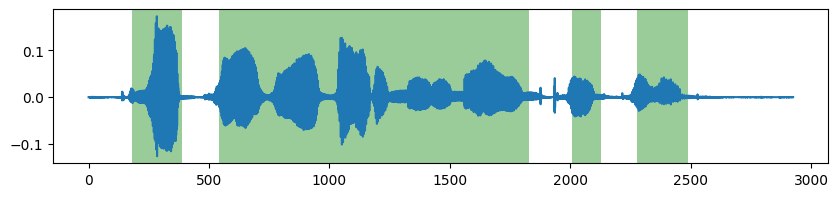

In [107]:
figure = plt.figure(figsize=(10, 2))
plt.plot(t, signal)

for i, label in enumerate(labels_per_frame):
    if label == 1:
        start = i * num_frame_samples
        end = start + num_frame_samples - 1

        plt.axvspan(t[start], t[end], alpha=0.4, fc='g')


In [140]:
preemphasis_coef = 0.97 # Coefficient for pre-processing filter
frame_length = 0.025 # Window length in sec
frame_step = 0.01 # Length of step in sec
num_nfft = 600 # Point for FFT
num_features = 32 # Number of Mel filters
n_frames = 32 # Number of frames for uniting in image

res = python_speech_features.base.logfbank(
    signal=signal,
    samplerate=freq,
    winlen=frame_length,
    winstep=frame_step,
    nfilt=num_features,
    nfft=num_nfft,
    lowfreq=0,
    highfreq=None,
    preemph=preemphasis_coef,
)
print(res.shape)

(291, 32)


(32, 291)


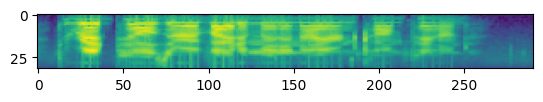

In [125]:
print(res.T.shape)
plt.imshow(res.T)

In [126]:
def readLabels(path, sample_rate):
    '''
    Read the file and return the list of SPEECH/NONSPEECH labels for each frame
    '''
        
    labeled_list  = []
    grid = textgrids.TextGrid(path)

    for interval in grid['silences']:
        label = int(interval.text)

        dur = interval.dur
        dur_samples = int(np.round(dur * sample_rate)) # sec -> num of samples
        
        for i in range(dur_samples):
            labeled_list.append(label)

    return labeled_list


markers = readLabels(ann_path, freq)

In [130]:
markers_of_frames = python_speech_features.sigproc.framesig(
    sig=markers,
    frame_len=frame_length * freq,
    frame_step=frame_step * freq,
    winfunc=np.ones,
)

In [139]:
markers_of_frames.shape

(291, 551)